In [64]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(funModeling) 
library(Hmisc)
library(GGally)
library(car)
library(janitor)
library(scales)
library(car)
library(glmnet)

In [47]:
data<- read.csv("https://raw.githubusercontent.com/Zibo-S/STAT301_GP_4/main/insurance.csv", header= TRUE)

In [48]:
data%>%head(3)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.90,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.552
3,28,male,33.00,3,no,southeast,4449.462


## Methods: Plan

We plan to use LASSO to fit a linear regression to predict the charges someone might have to pay given different parameters. Because we are using LASSO(3) to find the most accurate model, we do not know what these parameters will be, but we know that they will be a subset of the ones mentioned earlier. <br>
We can then quantify the model's performance by calculating the root mean squared error (RMSE) that it achieves on the training set. With this, we expect to achieve a model capable of predicting the charges of a patient, which can give more insight into what factors influence charges the most and allow patients to predict the average price that they might have to pay for a visit to the hospital.

**1. split data into training and testing sets (70% vs 30%)**

In [134]:
# split data into training and testing sets
set.seed(1234)

data$ID <- 1:nrow(data)
training_set <- sample_n(data, size = nrow(data) * 0.70,
  replace = FALSE
)

testing_set <- anti_join(data,
  training_set,
  by = "ID"
)

head(training_set, 3)
nrow(training_set)

head(testing_set, 3)
nrow(testing_set)

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,32,male,28.12,4,yes,northwest,21472.479,1308
2,26,female,34.20,2,no,southwest,3987.926,1018
3,23,female,42.75,1,yes,northeast,40904.200,1125


[1] 936

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,28,male,33.00,3,no,southeast,4449.462,3
2,32,male,28.88,0,no,northwest,3866.855,5
3,37,female,27.74,3,no,northwest,7281.506,8


[1] 402

Check data balancing for our target variable Charges by histogram.

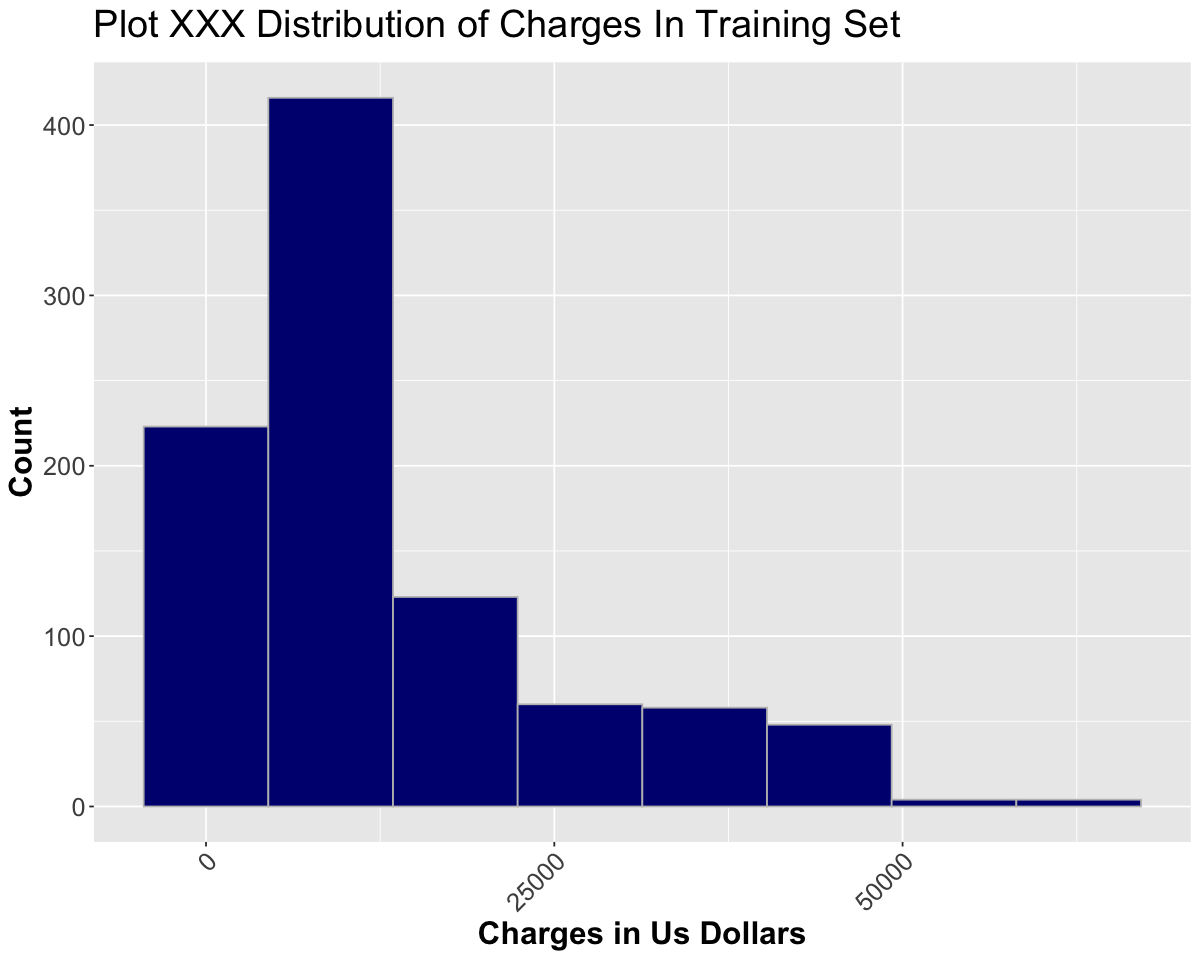

In [59]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_charges <- ggplot(training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )+ 
  ggtitle(expression("Plot XXX Distribution of Charges In Training Set"))
hist_charges

As we can see, there are less count for chargers over $25000, which make sense, since less people are being charged for higher amount.

**2. Perform Data tranformation to the training dataset**

In this project, a `log-transformation` is performed to all the numeric variables, for the purpose of reduces or removes the skewness of our training data.<br>
Since glmnet cannot handle categorical variables directly, transferring categorical variables to a binary representation. 

In [135]:
# drop feature 'ID' since it is irrelevant to our target
training_set=training_set[-8]

In [136]:
tran_training_set<- training_set %>% mutate(age = log(age),
                                            sex = factor(sex),
                                            bmi = log(bmi),
                                            smoker = factor(smoker),
                                            region = factor(region),
                                            charges = log(charges),
                                           )
# 0 for female and 1 for male
levels(tran_training_set$sex) <- c(0,1)

# 1 for yes and 0 for no
levels(tran_training_set$smoker) <- c(0,1)

# northeast = 0, northwest = 1,southeast = 2, southwest = 3, 
levels(tran_training_set$region) <- c(0,1,2,3)

tran_training_set%>%head(5)

,age,sex,bmi,children,smoker,region,charges
,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<dbl>
1,3.465736,1,3.336481,4,1,1,9.974527
2,3.258097,0,3.532226,2,0,3,8.291027
3,3.135494,0,3.755369,1,1,0,10.618988
4,3.871201,1,3.387774,0,0,3,9.963273
5,3.891820,0,3.058707,1,0,3,9.125019


In [143]:
tran_training_set<- tran_training_set %>% mutate(sex = as.integer(sex),
                                            smoker = as.integer(smoker),
                                            region = as.integer(region)
                                           )

In [144]:
tran_training_set%>%head(5)

,age,sex,bmi,children,smoker,region,charges
,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,3.465736,2,3.336481,4,2,2,9.974527
2,3.258097,1,3.532226,2,1,4,8.291027
3,3.135494,1,3.755369,1,2,1,10.618988
4,3.871201,2,3.387774,0,1,4,9.963273
5,3.891820,1,3.058707,1,1,4,9.125019


Check data balancing again using transfered target variable Charges by histogram.

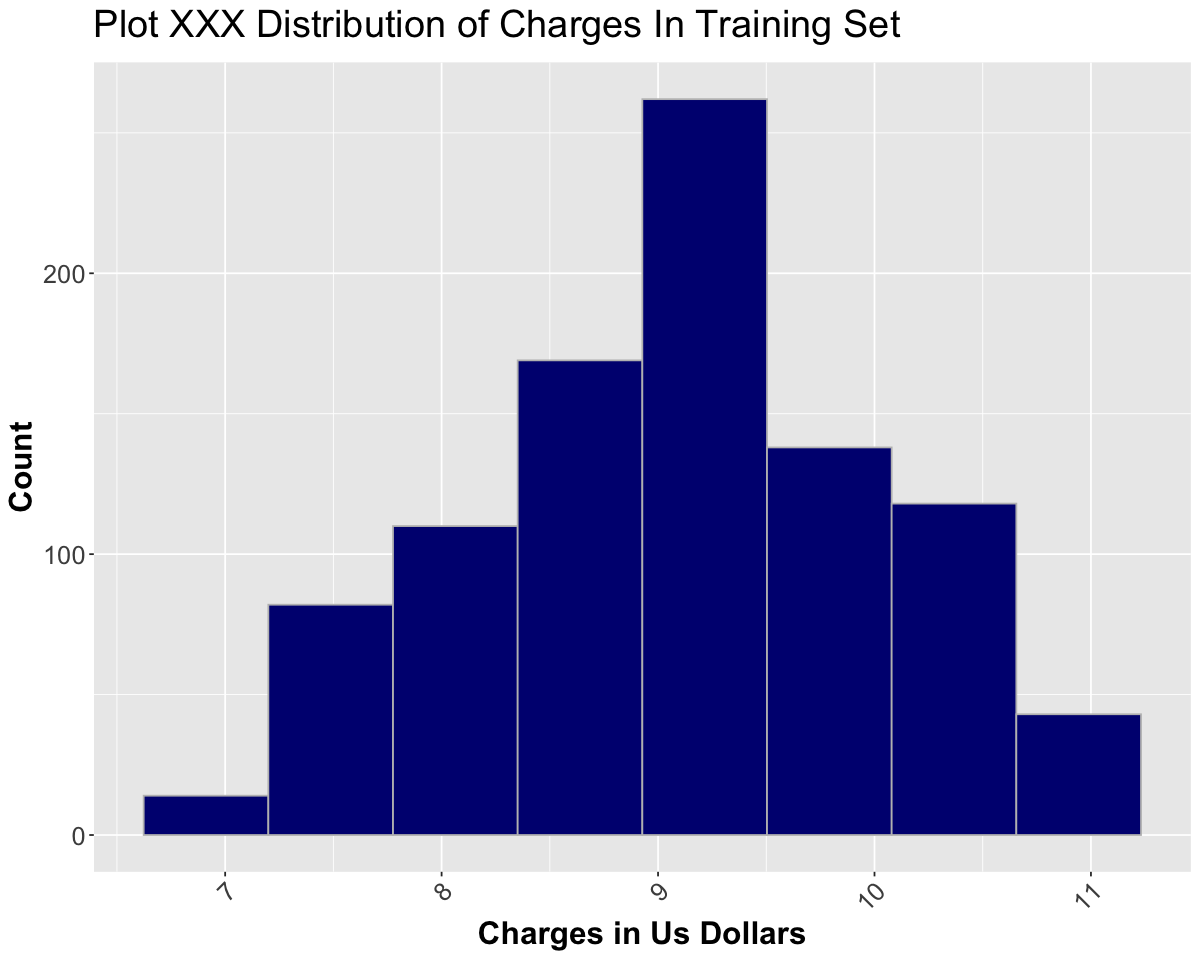

In [139]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_tran_charges <- ggplot(tran_training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )+ 
  ggtitle(expression("Plot XXX Distribution of Charges In Training Set"))
hist_tran_charges

From the plot above, the distribution of our transferred target variable is more Normally distributed.

**3. Feature Selection by using Lasso**

10 fold cross-validation is carried out to find the best model

In [172]:
x_train <-model.matrix(tran_training_set$charges~tran_training_set$age+tran_training_set$sex+tran_training_set$bmi+tran_training_set$children+tran_training_set$smoker+tran_training_set$region)
lasso_model = cv.glmnet(x=x_train,y =tran_training_set$charges,alpha=1, nfolds=10)
lasso_model


Call:  cv.glmnet(x = x_train, y = tran_training_set$charges, nfolds = 10,      alpha = 1) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.00212    62  0.2129 0.02315       6
1se 0.07276    24  0.2347 0.01848       3

In [174]:
best_lambda <- lasso_model$lambda[which.min(lasso_model$cvm)]
best_lambda

[1] 0.002120854

Making a new Lasso model with the minimized lambda

In [175]:
best_model <- glmnet(x=x_train,y =tran_training_set$charges,alpha=1, lambda=best_lambda)

In [179]:
# tidy the model to a more readable formet
best_model%>%tidy()

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1,1.62869815,0.002120854,0.759245
tran_training_set$age,1,1.24948097,0.002120854,0.759245
tran_training_set$sex,1,-0.06508453,0.002120854,0.759245
tran_training_set$bmi,1,0.35827730,0.002120854,0.759245
tran_training_set$children,1,0.08949384,0.002120854,0.759245
tran_training_set$smoker,1,1.56928390,0.002120854,0.759245
tran_training_set$region,1,-0.04862655,0.002120854,0.759245
